# Text Classification with Supervised Machine Learning

The goal of text classification is to categorize texts into any number of predefined categories. This method is most similar to traditional content analysis, or text coding, in that it does the same thing as a team of trained coders: place texts into categories. 

Using supervised machine learning, we give an algorithm a dataset of training examples that say "here are specific features, and this is the category it belongs to". The algorithm trains a model to recognize important features and determine the category of an object (for us, a document); this model can then be used to predict the class of a new object given its known features. 

To train and evaluate our models, we will use [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html), which provides a full machine learning pipeline and many convenient functions in Python.

We will apply supervised machine learning to a corpus distributed by Ted Underwood and Jordan Sellers in support of their own [literary historical study](https://tedunderwood.com/2015/05/18/how-quickly-do-literary-standards-change/) on nineteenth- and early-twentieth century volumes of poetry. Some poems were reviewed in prestigious magazines, while others weren't--being reviewed is our outcome variable. Even a negative review indicates valuable, critical engagement, so predicting whether a poem is reviewed will tell us something about the vocabulary of literary prestige.

## Learning Goals
* Get comfortable with the basic vocabulary of text classification
* Understand the intuition behind supervised machine learning
* Learn how to implement logistic regression and its basic mechanics
* Learn how to test for accuracy
* Use scikit-learn to identify important features for each category
* Gain foundational knowledge for continued learning

## Outline

* [Introduction](#intro)
    * [Text classification in action](#example)
    * [Text classification basics](#basics)
* [Data preparation](#prepare)
    * [Import modules](#import)
    * [Read and preprocess data](#preprocess)
    * [Divide data into training and test sets](#split)
    * [Vectorize texts](#vectorize)
* [Classification with supervised machine learning](#supervised)
    * [Train logistic classifier model](#model)
    * [Prediction on new data](#prediction)
    * [Identify features](#features)

## Key Terms

* *supervised machine learning* :
    * Using machine learning to infer documents' classifications from labeled training data
* *model training* :
    * Using a machine learning algorithm to train a classifier to predict categories on unseen sets
* *features*:
    * Way of representing the object that will be classified. For images, features are often pixels. For text, features are usually word counts or weighted word counts, but they can also be things like a word's part of speech, proportion of capitals, or specific words that are used.
* *text vectorization*:
    * Converting natural language documents into numbers that can be fed into a classifier. Usually this means converting a corpus into a document-term matrix.
* *document-term matrix (DTM)*:
    * A common text vectorization method: essentially a big table where the rows are articles, the columns are words, and each cell indicates the number of a times a given word appears in a given article. The cells can be either raw counts or weighted proportions, like with term frequency inverse document frequency (TF-IDF) weighting--which gives a word greater weight both when it is more frequent in a text AND when it is rare across the corpus. 
* *train-test split*:
    * Dividing labeled data into a training set and a test set. Often done once in supervised machine learning model training, but can be done several times independently as in cross-validation
* *training set*:
    * A selection of labeled data that is used to train the machine learning algorithm
* *test set*:
    * A selection of labeled data that is used to test the accuracy of the machine learning algorithm
* *unseen set*:
    * A selection of *unlabeled* data - the machine learning algorithm predicts the label for these data. Also called the *holdout set*

# Introduction<a id='intro'></a>

## Text classification in action<a id='example'></a>

Imagine that you work at [YouTube](https://www.youtube.com/) (if you haven't heard of it, YouTube is a video-sharing website). Your job is to remove comments on videos that are spam (unsolicited and inappropriate comments). You look through each video and read the comments yourself, deciding which are spam and which are not spam. Perhaps you see comments like those below. Which would you consider to be spam and which not spam?

- _Hey @dancer317, love ur videos so much! Thanks for all the tips on dancing!_
- _OUR  LASER PRINTER/FAX/COPIER TONER CARTRIDGE PRICES NOW AS LOW AS 39 DOLLARS. SPECIALS WEEKLY ON ALL LASER PRINTER SUPPLIES. WE CARRY MOST ALL LASER PRINTER CARTRIDGES, FAX SUPPLIES AND COPIER TONERS AT WAREHOUSE PRICES_
- _I'm not sold on your first point about crossing national boundaries, but I see what you mean about non-economic alternatives._
- _Some of the most beautiful women in the world bare it all for you. Denise Richards, Britney  Spears, Jessica Simpson, and many more. CLICK HERE FOR NUDE CELEBS_

How did you decide which were spam and which weren't? Maybe one thing you noted was the high number of words in all capitals. The topics can also give you a clue, as the spam-like comments talk about selling things and nudity, which are often found in spam comments.

However you decided, we can think about the task you were doing like this:

<img src='../assets/human-classification.jpg' />

You took a comment written in English, and you classified it into one of two classes: spam or not spam. This is text classification, performed by a human. Wouldn't it be nice to have a computer do this for you? That would look like this: 

<img src='../assets/computer-classification.jpg' />

How are we going to do this? We could count the number of times each YouTube comment mentions nudity or tries to sell something, and we could measure the proportion of capital letters. Using this approach, we would get two numbers for each comment, one for each of these _features_. We could also use your human judgements in a third column telling us whether that comment is spam or not.

| Comment                                                 | Selling or nudity | Proportion capital letters | Is it spam? |
|---------------------------------------------------------|-------------------|----------------------------|-------------|
| Hey @dancer317, love ur videos so much! Thanks for ...  | 0                 | 0.1                        | No          |
| OUR LASER PRINTER/FAX/COPIER TONER CARTRIDGE PRICES ... | 4                 | 1.0                        | Yes         |
| I'm not sold on your first point ...                    | 1                 | 0.05                       | No          |
|  Some of the most beautiful women in the world ...      | 3                 | 0.15                       | Yes         |

We can treat these two numbers as geometric coordinates and plot them, with spam comments in red and non-spam comments in green, like so:

<img src='../assets/classification-no-line.jpg' />

<img src='../assets/classification-with-line.jpg' />

## Text classification basics<a id='basics'></a>

Text classification requires labeled text, or text that is already categorized into predefined categories. In some cases, this is built into the data; in others, the labels are assigned by hand. Once we have a good number of labeled texts, usually between 200 and 500, we can use supervised machine learning algorithms to train a model to recognize the categories and place the remaining, un-coded texts into a category. This method has two benefits: (1) It allows us to scale our coding up almost indefinitely, and (2) it identifies what *features* (in our case, words) are most defining of each category. This can help us learn more about the content of our categories.

Text classification involves two primary tasks:
- **Turning natural language into numbers.** (This is called _vectorization_.)
- **Training a classifier to use those numbers and distinguish between the classes.**

This is distinct from inductive natural language processing methods--such as topic modeling, which discover the categories making up texts rather than defining them from the outset. If you're testing hypotheses about buckets or categories of texts, you'll usually use classification; if you're exploring in the dark, you'll use a more exploratory method. Text categories to classify can also include genre, language, author, or [affective states][1].

[1]: https://en.wikipedia.org/wiki/Affect_(psychology)

Many applied natural language processing problems can be tackled as text classification:

- [Sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis)
- Genre classification
- Language identification
- Authorship attribution
- Is this document relevant to this legal case?
- Is the patient in need of urgent care?

# Data preparation<a id='preparation'></a>

## Import modules<a id='import'></a>

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#scikit-learn is a huge library. We import what we need.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split #shortcut for dividing into train and test data
from sklearn.metrics import confusion_matrix #shows confusion matrix--false/true positives/negatives
from sklearn.metrics import accuracy_score #to asses the accuracy of the algorithm
from sklearn.model_selection import cross_val_score #to compute cross validation for assessment purposes
from sklearn.svm import LinearSVC #Linear Support Vector Classifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV #Logistic regression classifier w/ and w/o cross-validation
from sklearn.naive_bayes import MultinomialNB #Naive Bayes classifier
from sklearn.neighbors import KNeighborsClassifier #nearest neighbors classifier
from sklearn.ensemble import RandomForestClassifier #Random Forest classifier

## Read and preprocess data<a id='preprocess'></a>

In [2]:
#read our texts and turn them into lists
import os
review_path = 'poems/reviewed/'
random_path = 'poems/random/'
review_files = os.listdir(review_path)
random_files = os.listdir(random_path)

review_texts = [open(review_path+file_name, encoding='utf-8').read() for file_name in review_files]
random_texts = [open(random_path+file_name, encoding='utf-8').read() for file_name in random_files]

review_texts[0] #notice the strange output here. These poems are saved in a bag of words format

"the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

In [3]:
#transform and concat these lists into a Pandas dataframe
df1 = pandas.DataFrame(review_texts, columns = ['body'])
df1['label'] = "review"
df2 = pandas.DataFrame(random_texts, columns = ['body'])
df2['label'] = "random"
df = pandas.concat([df1,df2])
df

,body,label
0,the the the the the the the the the the the th...,review
1,the the the the the the the the the the the th...,review
2,the the the the the the the the the the the th...,review
3,the the the the the the the the the the the th...,review
4,the the the the the the the the the the the th...,review
...,...,...
355,the the the the the the the the the the the th...,random
356,the the the the the the the the the the the th...,random
357,the the the the the the the the the the the th...,random
358,the the the the the the the the the the the th...,random


### Challenge

Output some summary statistics for this dataframe. 
- How many poems have the review label, and how many bear the random label? 
- What is the total number of words in each category? 
- What is the average number of words per poem in each category?

In [4]:
# your code here

In [5]:
print('Total number of poems in each category:\n', df['label'].value_counts(), '\n')
df['tokens'] = df['body'].str.split()
df['tokens'] = df['tokens'].str.len()

grouped = df.groupby('label')
print('Token totals in each category:', grouped['tokens'].sum(), '\n')
print('Token averages in each category:', grouped['tokens'].mean())

Total number of poems in each category:
 review    360
random    360
Name: label, dtype: int64 

Token totals in each category: label
random    7069809
review    8260352
Name: tokens, dtype: int64 

Token averages in each category: label
random    19638.358333
review    22945.422222
Name: tokens, dtype: float64


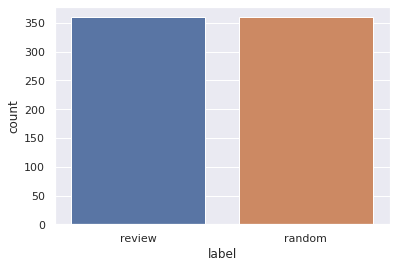

In [6]:
sns.countplot(df['label'], order=df['label'].value_counts().index);

## Divide data into training and test sets<a id='split'></a>

To avoid overfitting, let's train our classifier on a different dataset from what we test it on. To accomplish this, we'll split it into training and test sets: we'll train on the first 500 poems, and test the accuracy on the rest.

In [7]:
#randomize our rows
df = df.sample(720, random_state=0)
df

,body,label,tokens
143,the the the the the the the the the the the th...,random,23127
285,the the the the the the the the the the the th...,random,27121
245,the the the the the the the the the the the th...,review,11636
142,the the the the the the the the the the the th...,review,17512
133,the the the the the the the the the the the th...,random,18179
...,...,...,...
347,the the the the the the the the the the the th...,random,43518
192,the the the the the the the the the the the th...,review,36906
269,the the the the the the the the the the the th...,random,4603
199,the the the the the the the the the the the th...,random,32059


In [8]:
#create two new dataframes
df_train = df[:500]
df_test = df[500:]
df_train['label'].value_counts()

random    254
review    246
Name: label, dtype: int64

## Vectorize texts<a id='vectorize'></a>

Next, we turn the text into numbers for our classifier. We will use a "bag of words" approach to create our features: frequency counts of all the words that appear in a text. The "bag" name is because we ignore the order of the words; we just care about what words are in the text, as if we threw all the words into a bag and shook them up. To do this, we use `scikit-learn`'s `CountVectorizer` to build a document-term matrix (DTM). You can think of a DTM as a big table where the rows are articles, the columns are words, and each cell indicates the number of a times a given word appears in a given article. 

In [9]:
#transform the 'body' column into a document term matrix
countvec = CountVectorizer(stop_words = 'english', min_df = 1, binary=True)

training_dtm_tf = countvec.fit_transform(df_train.body)
test_dtm_tf = countvec.transform(df_test.body)

#create an array for labels
training_labels = df_train.label
test_labels = df_test.label
test_labels.value_counts()

review    114
random    106
Name: label, dtype: int64

# Classification with supervised machine learning<a id='supervised'></a>

## Train logistic classifier model<a id='model'></a>

Now that we've turned our data into numbers, we're ready to feed it into a classifier--starting with a logistic classifier. It's good to know what our code is doing, so let's go over how this works at a high level.

Logistic models fit where the probability of being positive ($y=1$) is described by a sigmoid function of the form:
$f(X)=P(y=1|X)=\frac{exp(-X'\theta)}{1+exp(-X'\theta)}$. Once $\theta$ - a vector of word _weights_ or _loadings_ - is estimated we can predict outcomes $\hat{f}$ conditional on observed word count $X$. If $\hat{f}>0.5$ then the observation is classified as positive. This is a _linear classifier_ as the decision boundary is defined by $\frac{exp(-X'\theta)}{1+exp(-X'\theta)}=0.5$, which after rearranging and taking logs appears equivalent to $-X'\theta=0$ - a linear function of the features $X$. The model is estimated through penalized Maximum Likelihood.

In [10]:
#define a container for our chosen algorithm, in this case logistic regression
logit = LogisticRegression()
#nb = MultinomialNB()

#fit a model on our training set
#one object contains all the functions for fitting data, making predictions, and storing parameters
logit.fit(training_dtm_tf, training_labels)

#predict the labels on the test set using the trained model
predictions_logit = logit.predict(test_dtm_tf) 
predictions_logit

array(['random', 'random', 'review', 'review', 'review', 'random',
       'review', 'random', 'random', 'random', 'random', 'random',
       'review', 'review', 'review', 'random', 'random', 'review',
       'random', 'random', 'review', 'review', 'review', 'review',
       'review', 'review', 'review', 'review', 'random', 'review',
       'review', 'random', 'review', 'review', 'random', 'review',
       'review', 'random', 'review', 'random', 'random', 'review',
       'review', 'random', 'random', 'random', 'review', 'review',
       'review', 'random', 'review', 'review', 'review', 'review',
       'review', 'random', 'random', 'random', 'review', 'review',
       'review', 'review', 'review', 'random', 'review', 'review',
       'random', 'review', 'random', 'random', 'random', 'review',
       'random', 'review', 'review', 'random', 'random', 'review',
       'review', 'random', 'review', 'review', 'random', 'random',
       'random', 'review', 'review', 'review', 'review', 'revi

We can use the built-in `accuracy_score` function to calculate the accuracy of our classifier. Basically, this number represents the proportion of texts an algorithm correctly classifies (we will go over this more tomorrow). 

In [11]:
accuracy_score(predictions_logit, test_labels)

0.7772727272727272

In [12]:
#let's see if tf-idf weighting improves the accuracy
tfidfvec = TfidfVectorizer(stop_words = 'english', min_df = 1, binary=True)
training_dtm_tfidf = tfidfvec.fit_transform(df_train.body)
test_dtm_tfidf = tfidfvec.transform(df_test.body)

logit.fit(training_dtm_tfidf, training_labels)
predictions_tfidf = logit.predict(test_dtm_tfidf) 
accuracy_score(predictions_tfidf, test_labels)

0.740909090909091

In the `fit_model` function defined below, we're going to use the logistic regression classifier described above to take in the numerical representation of the texts and spit out whether it's positive or negative. Then we'll use `test_model` to test the model's performance against our test data and print out some results.

Accuracy:  0.7272727272727273


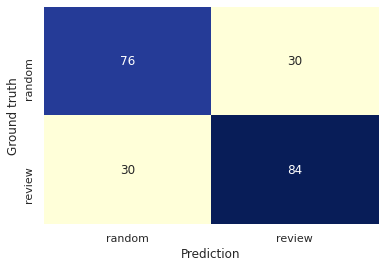

In [13]:
def fit_logistic_regression(X, y, cv=False):
    if cv:
        model = LogisticRegressionCV(Cs=5, penalty='l1', cv=3, solver='liblinear', refit=True)
    else:
        model = LogisticRegression(penalty='l1', solver='liblinear')
    model.fit(X, y)
    return model

def conmat(model, X, y):
    """Wrapper for sklearn's confusion matrix."""
    labels = model.classes_
    y_pred = model.predict(X)
    c = confusion_matrix(y, y_pred)
    sns.heatmap(c, annot=True, fmt='d', 
                xticklabels=labels, 
                yticklabels=labels, 
                cmap="YlGnBu", cbar=False)
    plt.ylabel('Ground truth')
    plt.xlabel('Prediction')
    
def test_model(model, X_test, y_test):
    conmat(model, X_test, y_test)
    print('Accuracy: ', model.score(X_test, y_test))
    

lr = fit_logistic_regression(training_dtm_tf, training_labels)

test_model(lr, test_dtm_tf, test_labels)

### Challenge

Try to improve the accuracy by changing some of the options. You can change options for either the vectorizer function, or one of the algorithms.

How does it change the accuracy of the classifier?

In [14]:
# your code here

In [15]:
nb = MultinomialNB(alpha = 0.1, fit_prior = True)
nb.fit(training_dtm_tf, training_labels)
predictions_nb = nb.predict(test_dtm_tf) 
accuracy_score(predictions_nb, test_labels)

0.740909090909091

In [16]:
svc = LinearSVC(max_iter=20) #dual = False, loss='hinge'
svc.fit(training_dtm_tf, training_labels)
predictions_svc = svc.predict(test_dtm_tf) 
accuracy_score(predictions_svc, test_labels)

/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.7636363636363637

## Prediction on new data<a id='prediction'></a>

Often what we want to do next is predict the label for unlabeled texts. Let's predict the label for two poems where we do not know the classification.

In [19]:
dickinson_canonic = """Because I could not stop for Death – 
He kindly stopped for me –  
The Carriage held but just Ourselves –  
And Immortality.

We slowly drove – He knew no haste
And I had put away
My labor and my leisure too,
For His Civility – 

We passed the School, where Children strove
At Recess – in the Ring –  
We passed the Fields of Gazing Grain –  
We passed the Setting Sun – 

Or rather – He passed us – 
The Dews drew quivering and chill – 
For only Gossamer, my Gown – 
My Tippet – only Tulle – 

We paused before a House that seemed
A Swelling of the Ground – 
The Roof was scarcely visible – 
The Cornice – in the Ground – 

Since then – ‘tis Centuries – and yet
Feels shorter than the Day
I first surmised the Horses’ Heads 
Were toward Eternity – """


anthem_patriotic = """O! say can you see, by the dawn's early light,
What so proudly we hailed at the twilight's last gleaming,
Whose broad stripes and bright stars through the perilous fight,
O'er the ramparts we watched, were so gallantly streaming?
And the rockets' red glare, the bombs bursting in air,
Gave proof through the night that our flag was still there;
O! say does that star-spangled banner yet wave
O'er the land of the free and the home of the brave?"""

In [20]:
# Transform these into DTMs with the same feature-columns as previously
unknown_dtm = countvec.transform([dickinson_canonic,anthem_patriotic]).toarray()

In [21]:
# Return binary classification
nb.predict(unknown_dtm)

array(['review', 'random'], dtype='<U6')

In [22]:
# Return probability of classification. 
# Bayes theorem assigns a probability of membership in either category.
# Just how confident is our classifier of its predictions?

nb.predict_proba(unknown_dtm)

array([[3.29533415e-04, 9.99670467e-01],
       [8.88143280e-01, 1.11856720e-01]])

In [23]:
#Let's zip this together with the name of the poems to make sense of the output
list(zip(['dickinson', 'anthem'], nb.predict(unknown_dtm), nb.predict_proba(unknown_dtm)))

[('dickinson', 'review', array([3.29533415e-04, 9.99670467e-01])),
 ('anthem', 'random', array([0.88814328, 0.11185672]))]

### Challenge

Import and process the 'canonic' (albeit unreviewed) volumes of poetry. Use the poetry classifier to predict whether they might have been reviewed.

What do you think of the output? Does it make sense?

In [24]:
# your code here

In [25]:
canonic_path = 'poems/canonic/'
canonic_files = os.listdir(canonic_path)
print(canonic_files)

canonic_texts = [open(canonic_path+file_name, encoding='utf-8').read() for file_name in canonic_files]

['256 Hopkins, Gerard Manley Poems of Gerard Manley Hopkins 1889.txt', '486 Dickinson, Emily Poems 1866.txt', '12 Lawrence, D. H. Look! We Have Come Through 1918.txt', '177 Hardy, Thomas Wessex Poems 1898.txt', '0 Lawrence, D. H. Tortoises 1921.txt', '169 Dunbar, Paul Laurence Lyrics of the Hearthside 1899.txt', '593 Brontë, Emily Poems of Acton, Currer, and Ellis Bell 1848.txt', '427 Harper, Frances Ellen Watkins Poems 1871.txt']


In [26]:
canonic_dtm = countvec.transform(canonic_texts).toarray()
nb.predict(canonic_dtm)

array(['review', 'review', 'review', 'review', 'review', 'random',
       'review', 'random'], dtype='<U6')

In [27]:
nb.predict_proba(canonic_dtm)

array([[3.92017184e-140, 1.00000000e+000],
       [4.49904061e-088, 1.00000000e+000],
       [5.07060513e-119, 1.00000000e+000],
       [2.82093581e-100, 1.00000000e+000],
       [1.23137556e-044, 1.00000000e+000],
       [1.00000000e+000, 5.99121033e-121],
       [5.38176285e-006, 9.99994618e-001],
       [1.00000000e+000, 5.14741899e-046]])

In [28]:
list(zip(canonic_files, nb.predict(canonic_dtm), nb.predict_proba(canonic_dtm)))

[('256 Hopkins, Gerard Manley Poems of Gerard Manley Hopkins 1889.txt',
  'review',
  array([3.92017184e-140, 1.00000000e+000])),
 ('486 Dickinson, Emily Poems 1866.txt',
  'review',
  array([4.49904061e-88, 1.00000000e+00])),
 ('12 Lawrence, D. H. Look! We Have Come Through 1918.txt',
  'review',
  array([5.07060513e-119, 1.00000000e+000])),
 ('177 Hardy, Thomas Wessex Poems 1898.txt',
  'review',
  array([2.82093581e-100, 1.00000000e+000])),
 ('0 Lawrence, D. H. Tortoises 1921.txt',
  'review',
  array([1.23137556e-44, 1.00000000e+00])),
 ('169 Dunbar, Paul Laurence Lyrics of the Hearthside 1899.txt',
  'random',
  array([1.00000000e+000, 5.99121033e-121])),
 ('593 Brontë, Emily Poems of Acton, Currer, and Ellis Bell 1848.txt',
  'review',
  array([5.38176285e-06, 9.99994618e-01])),
 ('427 Harper, Frances Ellen Watkins Poems 1871.txt',
  'random',
  array([1.00000000e+00, 5.14741899e-46]))]

## Identify features<a id='features'></a>

We can use supervised machine learning to classify unseen documents using the above code. But we can also use it to learn more about the content of each category, by extracting the most defining features of this category. So even if we do not have unseen text, we can use this method to better understand given categories (for example, canonized and non-canonized text). 

In [29]:
# Hand-waving the underlying statistics here...

def most_informative_features(text_class, vectorizer = countvec, classifier = nb, top_n = 20):

    feature_names = vectorizer.get_feature_names()
    class_index = np.where(classifier.classes_==(text_class))[0][0]
    
    class_prob_distro = np.exp(classifier.feature_log_prob_[class_index])
    alt_class_prob_distro = np.exp(classifier.feature_log_prob_[1 - class_index])
    
    odds_ratios = class_prob_distro / alt_class_prob_distro
    odds_with_fns = sorted(zip(odds_ratios, feature_names), reverse = True)
    
    return odds_with_fns[:top_n]

In [30]:
# Returns feature name and odds ratio for a given class
most_informative_features('review')

[(138.91433527740185, 'yews'),
 (129.7147104245939, 'unlighted'),
 (120.51508557178579, 'persephone'),
 (111.31546071897758, 'blurring'),
 (102.11583586616956, 'unbreathed'),
 (102.11583586616956, 'shambles'),
 (102.11583586616956, 'palimpsest'),
 (102.11583586616956, 'easeful'),
 (92.91621101336153, 'whetting'),
 (92.91621101336153, 'unrolling'),
 (92.91621101336153, 'piazza'),
 (92.91621101336153, 'overwrought'),
 (92.91621101336153, 'mouthpiece'),
 (92.91621101336153, 'exhalation'),
 (92.91621101336153, 'bigelow'),
 (83.71658616055348, 'unshamed'),
 (83.71658616055348, 'unrestful'),
 (83.71658616055348, 'uncut'),
 (83.71658616055348, 'unbearable'),
 (83.71658616055348, 'shrewish')]

In [31]:
most_informative_features('random')

[(131.52710239381815, 'minnie'),
 (120.65709393151899, 'instructions'),
 (120.65709393151899, 'acrostic'),
 (109.78708546922002, 'undertook'),
 (109.78708546922002, 'ke'),
 (109.78708546922002, 'indulging'),
 (109.78708546922002, 'frien'),
 (109.78708546922002, 'debase'),
 (109.78708546922002, 'alcohol'),
 (98.91707700692105, 'wrang'),
 (98.91707700692105, 'mell'),
 (98.91707700692105, 'investigation'),
 (98.91707700692105, 'fou'),
 (98.91707700692105, 'arranging'),
 (98.91707700692105, 'alane'),
 (88.047068544622, 'weans'),
 (88.047068544622, 'virus'),
 (88.047068544622, 'velvety'),
 (88.047068544622, 'val'),
 (88.047068544622, 'propelled')]

### Challenge

Look at the top fifty informative words for each category. 

What kinds of patterns do you notice?

In [32]:
# your code here

In [33]:
most_informative_features('review', top_n=50)

[(138.91433527740185, 'yews'),
 (129.7147104245939, 'unlighted'),
 (120.51508557178579, 'persephone'),
 (111.31546071897758, 'blurring'),
 (102.11583586616956, 'unbreathed'),
 (102.11583586616956, 'shambles'),
 (102.11583586616956, 'palimpsest'),
 (102.11583586616956, 'easeful'),
 (92.91621101336153, 'whetting'),
 (92.91621101336153, 'unrolling'),
 (92.91621101336153, 'piazza'),
 (92.91621101336153, 'overwrought'),
 (92.91621101336153, 'mouthpiece'),
 (92.91621101336153, 'exhalation'),
 (92.91621101336153, 'bigelow'),
 (83.71658616055348, 'unshamed'),
 (83.71658616055348, 'unrestful'),
 (83.71658616055348, 'uncut'),
 (83.71658616055348, 'unbearable'),
 (83.71658616055348, 'shrewish'),
 (83.71658616055348, 'sacristan'),
 (83.71658616055348, 'nighest'),
 (83.71658616055348, 'maenads'),
 (83.71658616055348, 'foliaged'),
 (83.71658616055348, 'belfries'),
 (83.71658616055348, 'austerely'),
 (74.51696130774539, 'woodwork'),
 (74.51696130774539, 'whitewashed'),
 (74.51696130774539, 'waterside

In [34]:
most_informative_features('random', top_n=50)

[(131.52710239381815, 'minnie'),
 (120.65709393151899, 'instructions'),
 (120.65709393151899, 'acrostic'),
 (109.78708546922002, 'undertook'),
 (109.78708546922002, 'ke'),
 (109.78708546922002, 'indulging'),
 (109.78708546922002, 'frien'),
 (109.78708546922002, 'debase'),
 (109.78708546922002, 'alcohol'),
 (98.91707700692105, 'wrang'),
 (98.91707700692105, 'mell'),
 (98.91707700692105, 'investigation'),
 (98.91707700692105, 'fou'),
 (98.91707700692105, 'arranging'),
 (98.91707700692105, 'alane'),
 (88.047068544622, 'weans'),
 (88.047068544622, 'virus'),
 (88.047068544622, 'velvety'),
 (88.047068544622, 'val'),
 (88.047068544622, 'propelled'),
 (88.047068544622, 'legislative'),
 (88.047068544622, 'ib'),
 (88.047068544622, 'fulton'),
 (88.047068544622, 'augmented'),
 (77.17706008232297, 'waur'),
 (77.17706008232297, 'vicksburg'),
 (77.17706008232297, 'vic'),
 (77.17706008232297, 'thocht'),
 (77.17706008232297, 'thae'),
 (77.17706008232297, 'sune'),
 (77.17706008232297, 'scientist'),
 (77